<img src="images/array_print.png" alt="Array Print" align="right"/>

# Array Print

<code>Array Print</code> takes a <code>.csv</code> containing a MITOMI-assayable library in a tabular format and returns a Scienion-compatible <code>.fld</code> file and a csv record of the array layout.

<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
import viz

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Project Configuration
Set all project parameters, print settings, and file paths. The csv file of your DNA library should have the following format:
| Plate | Well | Name | Rank | Block |
|-------|-----------------|------| ---- | ----- |
| 1     | A1              | Hsapiens_WT | 1 | 3 |

In [ ]:
# ========== PROJECT SETTINGS ==========
# Project name for output files
project_name = 'my-project'

# Input file path - UPDATE THIS for your project
library_csv = '/path/to/your/library.csv'

# Custom export directory (optional) - leave None to use ~/my-prints/
custom_export_dir = None  # or set to './personal_workspace/Micah-Prints/20240829-GCE-hAcyP2-test-set'

# ========== PRINT SETTINGS ==========
# Print options
skip_rows = True
catalytic_binning = False
using_blocked_device = True
n_blocks = 4

# Device dimensions
rows = 56
columns = 32
chambers = rows * columns

# Visualization settings
selected_mutant = '1A1'  # Mutant to highlight in position plots

# Create project directory
export_dir = utils.create_project_directory(project_name, custom_export_dir)

print(f"Project: {project_name}")
print(f"Library CSV: {library_csv}")
print(f"Export directory: {export_dir}")
print(f"Device: {rows}x{columns} = {chambers} chambers")
print(f"Blocks: {n_blocks} blocks" if using_blocked_device else "No blocking")

Project: hAcyP2-GCE-test-set
Library CSV: ./personal_workspace/Micah-Prints/20240829-GCE-hAcyP2-test-set/20240829-GCE-hAcyP2-test-set.csv
Export directory: /Users/micaholivas/my-prints/hAcyP2-GCE-test-set
Device: 56x32 = 1792 chambers
Blocks: 4 blocks


## Data Loading
Load and preprocess the DNA library CSV file to generate the `library_df` object.

**Note**: you should change these as required to

Initialize the library_df object

In [3]:
library_df = pd.read_csv(library_csv)
column_names = library_df.columns
library_members = library_df.Name.unique()

# drop rows with all NaN values
library_df = library_df.dropna(how='all')

# drop columns with all NaN values
library_df = library_df.dropna(axis=1, how='all')

# change plate, rank, and block columns to int
library_df['Plate'] = library_df['Plate'].astype(int)
library_df['Rank'] = library_df['Rank'].astype(int)
library_df['Block'] = library_df['Block'].astype(int)

if 'plate_position' in library_df.columns:
    library_df['Well'] = library_df['plate_position']

# Create Plate column if not present
if 'Plate' not in library_df.columns:
    library_df['Plate'] = library_df['plate_number']

# create plate_well column by combining plate and well columns as strings
library_df['plate_well'] = library_df['Plate'].astype(str) + library_df['Well'].astype(str)
library_df

display(library_df)

,Plate,Well,Name,Rank,Block,plate_well
0,1,A1,WT,1,1,1A1
1,1,A1,WT,1,2,1A1
2,1,A1,WT,1,3,1A1
3,1,A1,WT,1,4,1A1
4,1,A2,V13G,1,1,1A2
5,1,A3,V13A,1,1,1A3
6,1,A4,V13F,1,1,1A4
7,1,A5,V13*,1,2,1A5
8,1,A5,V13*,1,3,1A5
9,1,A5,V13*,1,4,1A5


## Generate print array

Generate print array with catalytic binning. The following algorithm does the following:
1. calculates the maximum number of allowed replicates per sequence
2. initializes a numpy array of chamber positions
3. assigns each sequence to a chamber position based on catalytic rank or random assignment

In [4]:
# add Name column to library_df
if 'member_name' in library_df.columns:
    library_df['Name'] = library_df['member_name'].str.replace(' ', '_')

In [13]:
# Generate optimized print array
print_array = utils.generate_print_array(
    library_df=library_df,
    columns=columns,
    rows=rows,
    skip_rows=False,
    using_blocked_device=using_blocked_device,
    n_blocks=n_blocks,
    catalytic_binning=catalytic_binning
)

# Convert to pandas DataFrame for display
print_df = pd.DataFrame(print_array)
print(f"Generated print array shape: {print_df.shape}")

Generated print array shape: (56, 32)


## Print Metrics
Generate comprehensive metrics for the print array

In [14]:
# Calculate and display print metrics
metrics = utils.get_print_metrics(print_array)
utils.print_metrics_summary(metrics)

PRINT METRICS SUMMARY
Total Variants: 22
Array Positions: 1792
Filled Positions: 1792
Blank Positions: 0
Fill Rate: 100.0%

REPLICATES PER VARIANT:
  Min: 17
  Max: 231
  Mean: 81.5
  Std Dev: 79.2

REPLICATE DISTRIBUTION:
  17 replicates: 1 variants
  20 replicates: 1 variants
  24 replicates: 2 variants
  26 replicates: 1 variants
  27 replicates: 3 variants
  29 replicates: 1 variants
  31 replicates: 1 variants
  32 replicates: 3 variants
  34 replicates: 2 variants
  183 replicates: 2 variants
  190 replicates: 1 variants
  193 replicates: 1 variants
  196 replicates: 1 variants
  200 replicates: 1 variants
  231 replicates: 1 variants


## Print metrics
Visualize the frequency of single sequences across array to ensure even distribution and no dropouts

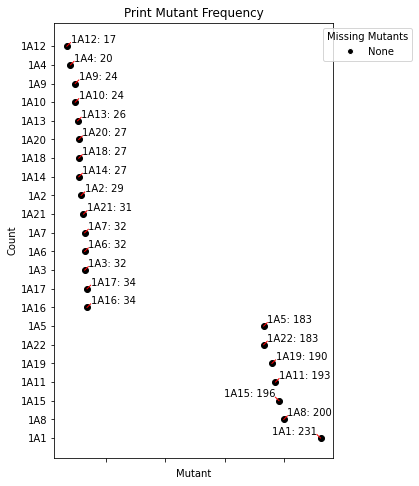

In [15]:
fig, ax = viz.plot_mutant_frequency(print_array, export_dir)
plt.show()

Visualize the position of a single mutant in the array

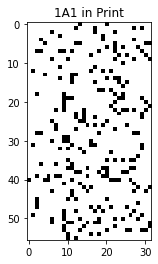

In [16]:
fig, ax = viz.plot_mutant_position(print_array, selected_mutant, export_dir)
plt.show()

### (If combining 96-well plates) Visualize 384-well plate layout

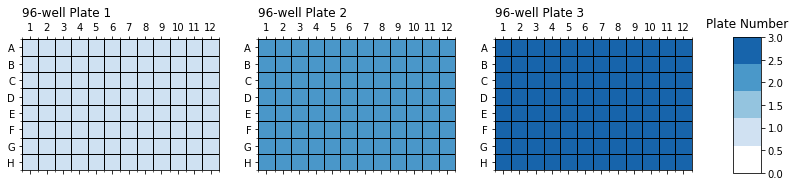

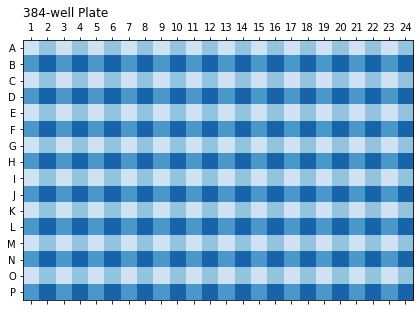

In [17]:
figs = viz.plot_plate_layouts(num_plates=3)
plt.show()

Demonstrate a helper function to consolidate 96-well plates in a 384-well plate layout.

'B19'

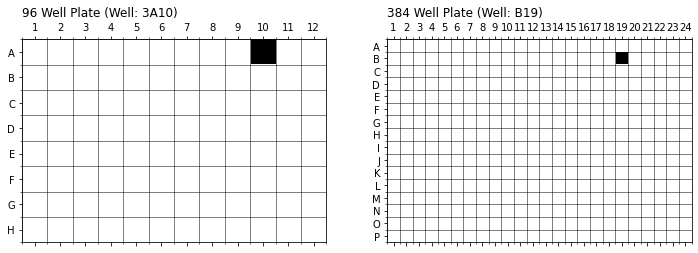

In [18]:
# Visualize the position of plate 3 well A10 (3A10)
utils.get_96_to_384('3A10')

Now, let's convert array to a 384-well plate layout.

Before proceeding, we'll also remove a few wells from one corner of the array. This will ensure that we can tell the orientation of the array after printing.

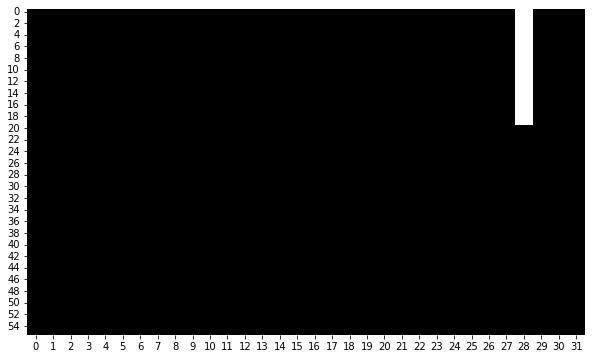

array([['1A21', '1A21', '1A3', ..., '1A22', '1A22', '1A15'],
       ['1A12', '1A21', '1A3', ..., '1A1', '1A15', '1A22'],
       ['1A6', '1A3', '1A7', ..., '1A11', '1A11', '1A5'],
       ...,
       ['1A16', '1A16', '1A12', ..., '1A1', '1A1', '1A19'],
       ['1A20', '1A18', '1A17', ..., '1A19', '1A15', '1A8'],
       ['1A16', '1A21', '1A18', ..., '1A11', '1A19', '1A22']],
      dtype=object)

In [19]:
# Modify array by removing part of a column 28
print_array_384 = viz.modify_array_column(print_array, column=28, depth=20)

# Visualize the modified array
fig, ax = viz.plot_array_heatmap(print_array_384)
plt.show()

print_array_384

## Output field file-formatted position list
Finally, the following cell writes a `.txt` file containing the array position list to the project folder.

In [20]:
print_df = pd.DataFrame(np.flip(print_array_384, axis=1)) # printing on Scienion flips the array
print_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1A15,1A22,1A22,,1A15,1A11,1A19,1A8,1A8,1A8,...,1A22,1A19,1A16,1A10,1A17,1A4,1A20,1A3,1A21,1A21
1,1A22,1A15,1A1,,1A1,1A11,1A5,1A11,1A15,1A8,...,1A15,1A11,1A21,1A13,1A6,1A13,1A14,1A3,1A21,1A12
2,1A5,1A11,1A11,,1A15,1A5,1A19,1A11,1A11,1A1,...,1A15,1A15,1A18,1A1,1A20,1A17,1A9,1A7,1A3,1A6
3,1A5,1A5,1A11,,1A15,1A11,1A8,1A5,1A8,1A15,...,1A22,1A1,1A7,1A6,1A10,1A13,1A18,1A17,1A2,1A10
4,1A19,1A22,1A22,,1A1,1A11,1A8,1A19,1A19,1A8,...,1A11,1A8,1A3,1A16,1A18,1A14,1A1,1A7,1A2,1A21
5,1A1,1A1,1A11,,1A5,1A5,1A5,1A11,1A5,1A1,...,1A8,1A19,1A7,1A10,1A6,1A1,1A9,1A10,1A9,1A21
6,1A22,1A22,1A11,,1A11,1A15,1A8,1A1,1A5,1A1,...,1A15,1A19,1A20,1A6,1A21,1A10,1A6,1A14,1A16,1A12
7,1A11,1A8,1A1,,1A19,1A5,1A11,1A15,1A8,1A1,...,1A1,1A1,1A13,1A12,1A2,1A17,1A1,1A1,1A7,1A9
8,1A8,1A1,1A15,,1A15,1A15,1A1,1A22,1A1,1A8,...,1A11,1A19,1A13,1A3,1A21,1A13,1A3,1A14,1A6,1A2
9,1A1,1A15,1A19,,1A1,1A15,1A8,1A19,1A11,1A1,...,1A5,1A5,1A17,1A1,1A18,1A17,1A7,1A4,1A21,1A9


## Save `fld` file body in `txt` output

Last, export this array to a fld file text output

In [21]:
# Generate final outputs
total_rows = print_df.shape[0]
total_columns = print_df.shape[1]

print("Generating FLD file...")
utils.write_fld(project_name, print_df, total_columns, total_rows, export_dir)

print(f"\nExport complete! Files saved to: {export_dir}")
print(f"- {project_name}_[timestamp].fld")
print(f"- metrics/print_mutant_frequency.png")
print(f"- metrics/{selected_mutant}_position_in_print.png")

Generating FLD file...

Export complete! Files saved to: /Users/micaholivas/my-prints/hAcyP2-GCE-test-set
- hAcyP2-GCE-test-set_[timestamp].fld
- metrics/print_mutant_frequency.png
- metrics/1A1_position_in_print.png


## After exporting...

The contents of the output `.txt` file can be copied into an existing Scienion-compattible `.fld` file for printing. When copying this over, ensure that the header and footer of the `.fld` file remain unchanged.